In [1]:
from openai import AzureOpenAI
import anthropic
import ollama
import requests
import json
from dotenv import load_dotenv
import os
from IPython.display import display, update_display, Markdown
from bs4 import BeautifulSoup
import re

In [27]:
load_dotenv(override=True)

azure_ai_foundary_api_key = os.getenv("AZURE_AI_FOUNDARY_API_KEY")
azure_oai_endpoint = os.getenv("AZURE_OAI_ENDPOINT")

azure_dalle_api_key = os.getenv("AZURE_DALLE_API_KEY")
azure_dalle_endpoint = os.getenv("AZURE_DALLE_ENDPOINT")

azure_audio_api_key = os.getenv("AZURE_AUDIO_API_KEY")
azure_audio_endpoint = os.getenv("AZURE_AUDIO_ENDPOINT")

In [24]:
azure_ai_foundary = AzureOpenAI(
    azure_endpoint = azure_oai_endpoint,
    api_key = azure_ai_foundary_api_key,
    api_version = "2025-01-01-preview"
)


## Tools
Tools allows the LLM to execute actions. Eg if there is a calculator tool then the LLM can use that whenever the user asks for a calculation.

In [4]:
product_prices = {'keyboard': 100, 'mouse': 40, 'motherboard': 143}

def get_product_price(product):
    """Returns the price of a computer part"""
    print(f'Price requested for {product}')
    return product_prices.get(product.lower(), 'Unknown')


# define the tool metadata for the LLM
# The structure follows the structure that open ai expects
computer_price_function = {
    "name": "get_product_price",
    "description": "Returns the price of a computer part. Use this whenever you need to know the price of a computer part. Example: If a customer asks for the price of a mouse, use his function.",
    "parameters": {
        "type": "object",
        "properties": {
            "product": {
                "type": "string",
                "description": "The name of the computer part that customer wants to buy"
            }
        },
        "required": ["product"],
        "additionalProperties": False
    }
}

tools = [{"type": "function", "function": computer_price_function}]

# This will be used to handle the tool request from open ai LLM
def tool_handler(message):
    # extract the func related args 
    tool_call = message.tool_calls[0]
    args = json.loads(tool_call.function.arguments)
    computer_part = args.get('product')

    print(f'Tool handler ........... {computer_part}')
    print(message)
    # use the func
    price = get_product_price(computer_part)

    response = {
        "role": "tool",
        "content": json.dumps({"product": computer_part, "price": price}),
        "tool_call_id": tool_call.id
    }

    return response

In [5]:
def chat(msg, history):
    system_message = "You are an expert assistant who specializes in computer related stuff. \
    You help the user precise one line responses. \
    If rely on functions to get the accuracy and in case you dont know about something, clearly mention that."

    model = "gpt-4o-mini"
    
    messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": msg}]

    # NOTE - pass the tools object
    response = azure_ai_foundary.chat.completions.create(model=model, messages=messages, tools=tools)
    
    # whenever the llm wants to use a tool, it will have that as the finish_reason
    if response.choices[0].finish_reason == "tool_calls":
        message = response.choices[0].message
        tool_response = tool_handler(message)

        # messages + [Received LLM tool call msg] + [our tool handler response]
        messages.append(message)
        messages.append(tool_response)

        response = azure_ai_foundary.chat.completions.create(model=model, messages=messages)

    return response.choices[0].message.content

In [6]:
import gradio as gr

c:\Users\SeekerG\Desktop\Dev\github\llm-apps\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
gr.ChatInterface(
    fn=chat,
    type="messages"
).launch()

* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


## Image generation

In [10]:
import base64
from PIL import Image
from io import BytesIO
from IPython.display import display

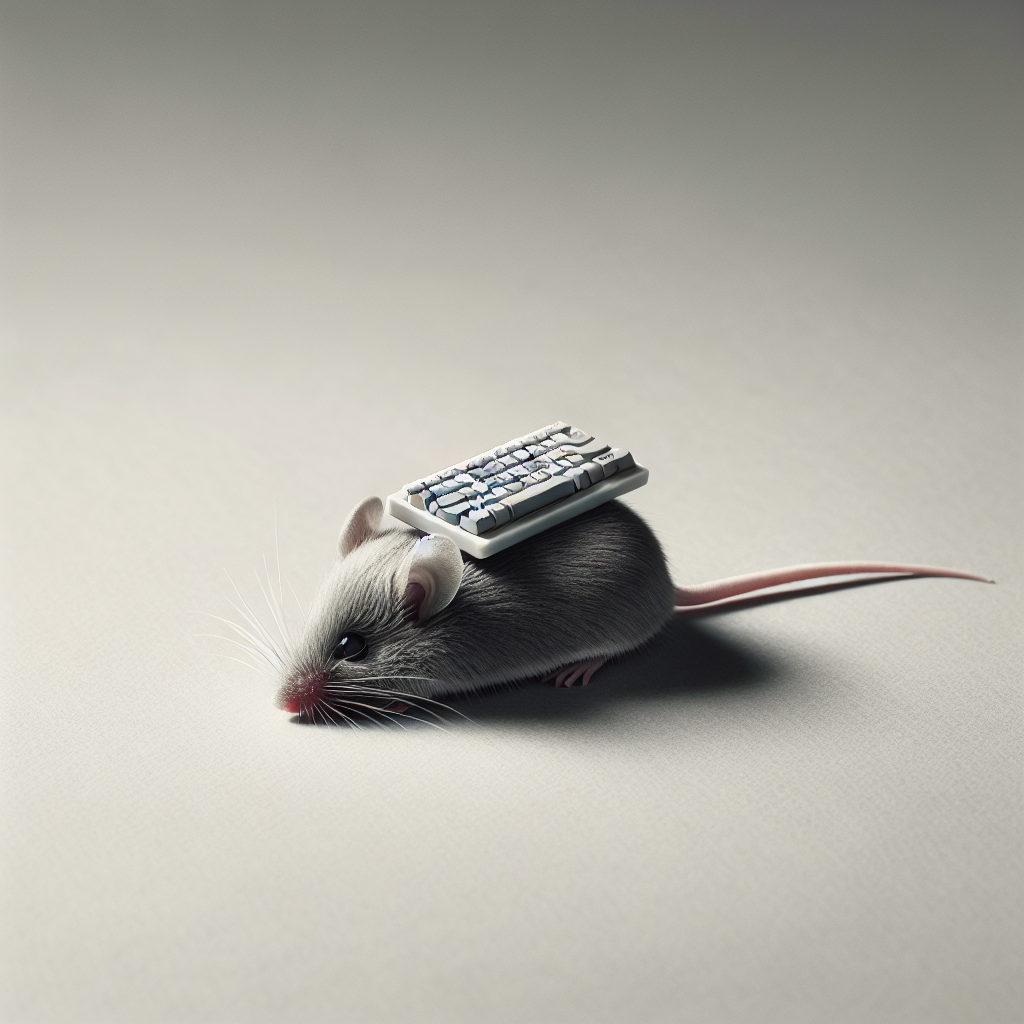

In [23]:
img_gen_client = AzureOpenAI(
    azure_endpoint=azure_dalle_endpoint,
    api_key=azure_dalle_api_key,
    api_version="2024-02-01"
)

def generate_img(prompt: str):
    model = "dall-e-3"
    img_response = img_gen_client.images.generate(
        model=model,
        prompt=prompt,
        size='1024x1024',
        n=1,
        response_format="b64_json"
    )

    img_b64 = img_response.data[0].b64_json
    # decode the base64 data to img
    img_bytes = base64.b64decode(img_b64)
    img = Image.open(BytesIO(img_bytes))

    return img

img = generate_img("mouse with a keyboard on top of it")
display(img)

## Audio Output

In [41]:
from pydub import AudioSegment
from pydub.playback import play
from openai.helpers import LocalAudioPlayer
from IPython.display import Audio

In [44]:
audio_gen_client = AzureOpenAI(
    azure_endpoint=azure_audio_endpoint,
    api_key=azure_audio_api_key,
    api_version="2025-03-01-preview"
)

def generate_audio(prompt: str):
    audio_response = audio_gen_client.audio.speech.create(
        model="gpt-4o-mini-tts",
        voice="alloy",
        input="""Hello, and welcome to your moment of mindfulness. I'm so glad you're here.""",
        instructions="""Voice Affect: Soft, gentle, soothing; embody tranquility.\n\nTone: Calm, reassuring, peaceful; convey genuine warmth and serenity.\n\nPacing: Slow, deliberate, and unhurried; pause gently after instructions to allow the listener time to relax and follow along.\n\nEmotion: Deeply soothing and comforting; express genuine kindness and care.\n\nPronunciation: Smooth, soft articulation, slightly elongating vowels to create a sense of ease.\n\nPauses: Use thoughtful pauses, especially between breathing instructions and visualization guidance, enhancing relaxation and mindfulness.""",
        response_format="mp3",
    )

    return audio_response

audio_response = generate_audio("Hello, this is a test of the text-to-speech functionality.")


In [45]:
def play_audio_stream(audio_response):
    audio_stream = BytesIO(audio_response.content)
    output_filename = "output_audio.mp3"
    with open(output_filename, "wb") as f:
        f.write(audio_stream.read())

    # Play the generated audio
    display(Audio(output_filename, autoplay=True))

play_audio_stream(audio_response)

In [ ]:
# we can also use openai helper to play the audio
await LocalAudioPlayer().play(audio_response)